In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, confusion_matrix

from sklearn.calibration import CalibratedClassifierCV


from sklearn.metrics import f1_score,precision_recall_curve,roc_curve, recall_score,precision_score

from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

In [2]:
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [3]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)

In [4]:
%%time
Path ='../input/india-ml/'
train_df = pd.read_csv(Path+'train/train.csv')
test_df = pd.read_csv(Path+'test/test.csv')
subm_df = pd.read_csv(Path+'sample_submission/sample_submission.csv')

targetcol = 'm13'
target = train_df[targetcol]

CPU times: user 656 ms, sys: 264 ms, total: 920 ms
Wall time: 960 ms


In [5]:
# subm_df.head()

In [6]:
print(train_df.shape, test_df.shape)
print(test_df.shape[0] / train_df.shape[0])

(116058, 29) (35866, 28)
0.309035137603612


In [7]:
train_df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1


In [8]:
print(train_df['source'].value_counts())
print(test_df['source'].value_counts())
print(np.sort(train_df['financial_institution'].unique()))
print(np.sort(test_df['financial_institution'].unique()))
print(train_df['financial_institution'].value_counts())
print(test_df['financial_institution'].value_counts())
print(train_df['loan_purpose'].value_counts())
print(test_df['loan_purpose'].value_counts())

X    63858
Y    37554
Z    14646
Name: source, dtype: int64
X    19714
Y    11653
Z     4499
Name: source, dtype: int64
['Anderson-Taylor' 'Browning-Hart' 'Chapman-Mcmahon'
 'Cole, Brooks and Vincent' 'Edwards-Hoffman' 'Martinez, Duffy and Bird'
 'Miller, Mcclure and Allen' 'Nicholson Group' 'OTHER' 'Richards-Walters'
 'Richardson Ltd' 'Romero, Woods and Johnson'
 'Sanchez, Hays and Wilkerson' 'Sanchez-Robinson' 'Suarez Inc'
 'Swanson, Newton and Miller' 'Taylor, Hunt and Rodriguez'
 'Thornton-Davis' 'Turner, Baldwin and Rhodes']
['Anderson-Taylor' 'Browning-Hart' 'Chapman-Mcmahon'
 'Cole, Brooks and Vincent' 'Edwards-Hoffman' 'Martinez, Duffy and Bird'
 'Miller, Mcclure and Allen' 'Nicholson Group' 'OTHER' 'Richards-Walters'
 'Richardson Ltd' 'Romero, Woods and Johnson'
 'Sanchez, Hays and Wilkerson' 'Sanchez-Robinson' 'Suarez Inc'
 'Swanson, Newton and Miller' 'Taylor, Hunt and Rodriguez'
 'Thornton-Davis' 'Turner, Baldwin and Rhodes']
OTHER                          49699
Browning-Ha

In [9]:
#categorical
#loan_purpose, financial_institution, source
#date origination_date, first_payment_date (only month and year mm/yyyy)

In [10]:
# test_df.head()

In [11]:
#check if there are any missing data.

def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [12]:
%%time
missing_data(train_df)

CPU times: user 172 ms, sys: 12 ms, total: 184 ms
Wall time: 180 ms


,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,int64,object,object,float64,int64,int64,object,object,int64,float64,float64,float64,object,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [13]:
train_df[train_df['loan_purpose'].isnull()].shape

(0, 29)

In [14]:
%%time
missing_data(test_df)

CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 47.5 ms


,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,int64,object,object,float64,int64,int64,object,object,int64,int64,int64,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [15]:
%%time
train_df.describe()

CPU times: user 188 ms, sys: 56 ms, total: 244 ms
Wall time: 237 ms


,loan_id,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
count,1.160580e+05,116058.000000,1.160580e+05,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000
mean,5.494155e+11,3.868961,2.082262e+05,292.280997,67.431939,1.593186,30.742293,769.926778,2.786288,459.611565,0.003257,0.003197,0.002059,0.001973,0.002180,0.003533,0.003421,0.004162,0.004825,0.005359,0.006617,0.007109,0.008065,0.005480
std,2.597560e+11,0.461020,1.146851e+05,89.762415,17.291719,0.491242,9.730798,42.210706,8.096464,381.946926,0.056977,0.063354,0.051391,0.055427,0.062161,0.082638,0.087553,0.100961,0.113128,0.128242,0.148430,0.162884,0.178128,0.073824
min,1.000009e+11,2.250000,1.100000e+04,60.000000,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.244656e+11,3.500000,1.200000e+05,180.000000,57.000000,1.000000,23.000000,751.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.486239e+11,3.875000,1.830000e+05,360.000000,72.000000,2.000000,31.000000,782.000000,0.000000,740.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.743034e+11,4.125000,2.780000e+05,360.000000,80.000000,2.000000,39.000000,800.000000,0.000000,791.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.999971e+11,6.750000,1.200000e+06,360.000000,97.000000,2.000000,64.000000,840.000000,40.000000,836.000000,1.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,1.000000


In [16]:
%%time
test_df.describe()

CPU times: user 92 ms, sys: 4 ms, total: 96 ms
Wall time: 94.5 ms


,loan_id,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
count,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000,35866.000000
mean,17933.500000,3.872850,207764.846930,293.130123,67.388334,1.596805,30.762867,769.926504,2.729409,462.436681,0.003178,0.002844,0.002314,0.001952,0.002007,0.002705,0.002370,0.003374,0.003680,0.004322,0.005548,0.006162,0.007333
std,10353.766714,0.460537,114561.745828,89.298799,17.246741,0.490546,9.726146,41.779664,8.029155,381.314899,0.056289,0.060600,0.058991,0.056838,0.059238,0.071770,0.066958,0.086539,0.092898,0.099676,0.121322,0.141455,0.160602
min,1.000000,2.375000,15000.000000,60.000000,5.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8967.250000,3.500000,119000.000000,180.000000,57.000000,1.000000,23.000000,751.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,17933.500000,3.875000,182000.000000,360.000000,72.000000,2.000000,31.000000,782.000000,0.000000,742.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,26899.750000,4.125000,278000.000000,360.000000,80.000000,2.000000,39.000000,799.000000,0.000000,791.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,35866.000000,6.625000,802000.000000,360.000000,97.000000,2.000000,55.000000,839.000000,35.000000,832.000000,1.000000,3.000000,4.000000,5.000000,5.000000,6.000000,6.000000,7.000000,5.000000,6.000000,7.000000,8.000000,9.000000


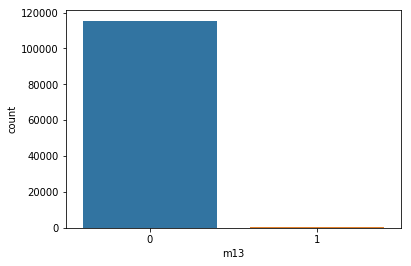

In [17]:
sns.countplot(train_df[targetcol])

In [18]:
print("There are {}% target values with 1".format(100 * train_df[targetcol].value_counts()[1]/train_df.shape[0]))

There are 0.5480018611383963% target values with 1


Density Plots

In [19]:
def plot_feature_distribution(df1, df2, label1, label2, features,rows=6,cols=4):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,4,figsize=(18,22))

    for feature in features:
        print('cur feature:',feature)
        i += 1
        plt.subplot(rows,cols,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

In [20]:
t0 = train_df.loc[train_df[targetcol] == 0]
t1 = train_df.loc[train_df[targetcol] == 1]
exclude_cols =['loan_id','financial_institution','origination_date',
               'first_payment_date','loan_purpose','source',targetcol]
features = [col for col in train_df.columns if col not in exclude_cols]

print(len(features))

22


cur feature: interest_rate
cur feature: unpaid_principal_bal
cur feature: loan_term
cur feature: loan_to_value
cur feature: number_of_borrowers
cur feature: debt_to_income_ratio
cur feature: borrower_credit_score
cur feature: insurance_percent
cur feature: co-borrower_credit_score
cur feature: insurance_type
cur feature: m1
cur feature: m2
cur feature: m3
cur feature: m4
cur feature: m5
cur feature: m6
cur feature: m7
cur feature: m8
cur feature: m9
cur feature: m10
cur feature: m11
cur feature: m12


<Figure size 432x288 with 0 Axes>

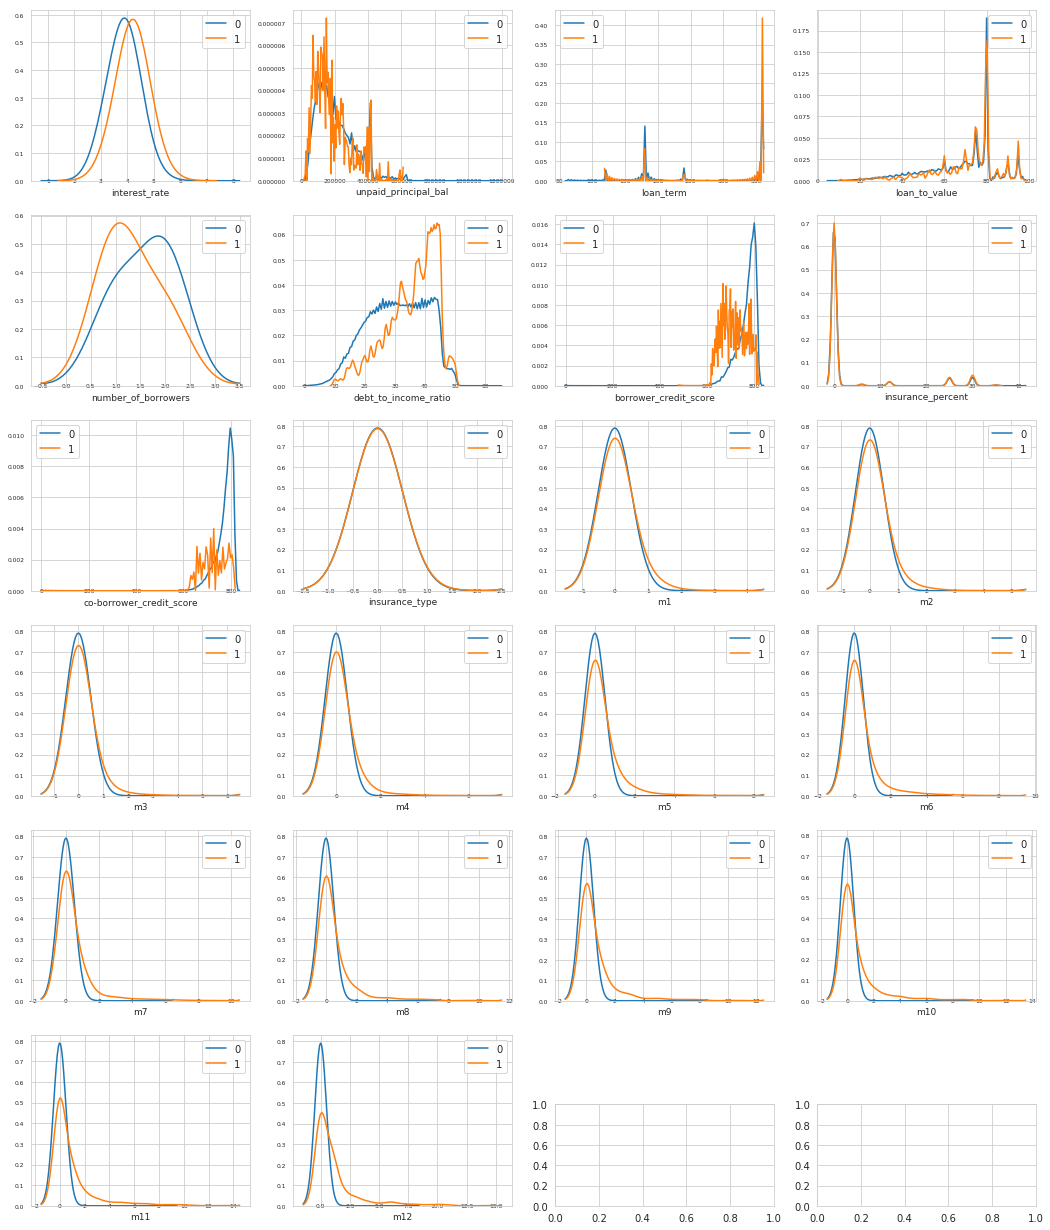

In [21]:
# features = train_df.columns.values[1:40]
plot_feature_distribution(t0, t1, '0', '1', features)

1
cur feature: loan_term


<Figure size 432x288 with 0 Axes>

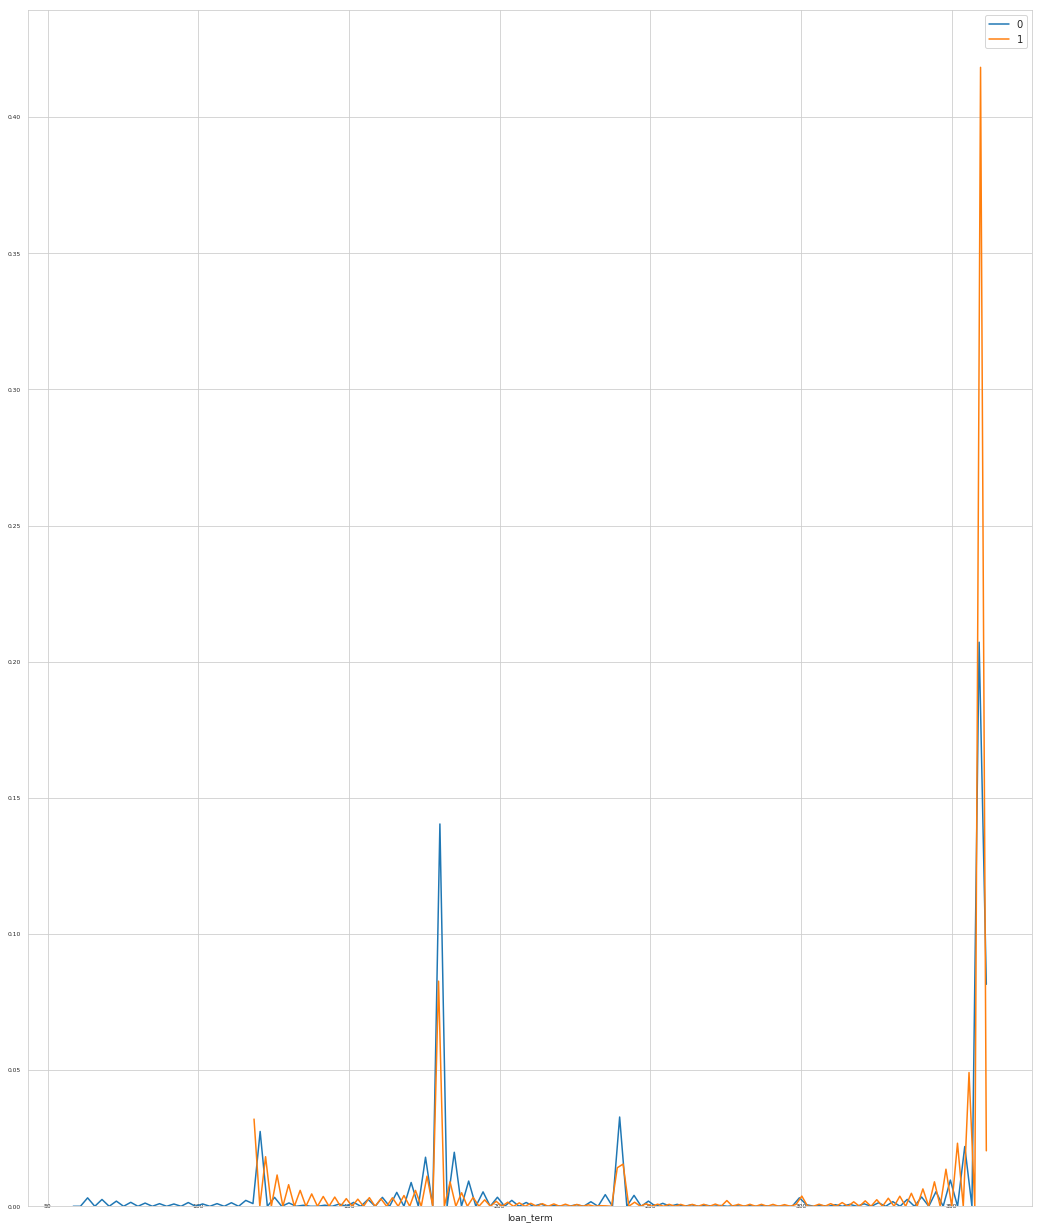

In [22]:
t0 = train_df.loc[train_df[targetcol] == 0]
t1 = train_df.loc[train_df[targetcol] == 1]

features = ['loan_term']

print(len(features))

# features = train_df.columns.values[1:40]
plot_feature_distribution(t0, t1, '0', '1', features,rows=1,cols=1)

Duplicate Values

In [23]:
len(list(train_df.columns))

29

In [24]:
%%time
features = train_df.columns.values[1:40]
exclude_cols =['loan_id','financial_institution','origination_date',
               'first_payment_date','loan_purpose','source',targetcol]
features = [col for col in train_df.columns if col not in exclude_cols]

# unique_max_train = []
# unique_max_test = []
# for feature in features:
#     values = train_df[feature].value_counts()
#     unique_max_train.append([feature, values.max(), values.idxmax()])
#     values = test_df[feature].value_counts()
#     unique_max_test.append([feature, values.max(), values.idxmax()])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 133 µs


In [25]:
# np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
#             sort_values(by = 'Max duplicates', ascending=False).head(40))

In [26]:
# np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
#             sort_values(by = 'Max duplicates', ascending=False).head(15))

Model

In [27]:
# exclude_cols =['Date.of.Birth','Employment.Type','DisbursalDate',
#                'PERFORM_CNS.SCORE.DESCRIPTION','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH',
#                'UniqueID',targetcol]
# features = [c for c in train_df.columns if c not in exclude_cols]
# print(features)

In [28]:
#generate new features
train_df['istrain']=1
test_df['istrain']=0
catcols =['source','financial_institution','loan_purpose']
combined= pd.concat([train_df,test_df],axis=0)
# combined = pd.get_dummies(combined[features + catcols + ['istrain']])
combined = pd.get_dummies(combined[ catcols + ['istrain']])

train_dummies = combined[combined['istrain']==1]
test_dummies = combined[combined['istrain']==0]

del combined, train_dummies['istrain'],test_dummies['istrain'], train_df['istrain'], test_df['istrain']

train_df= pd.concat([train_df,train_dummies],axis=1)
test_df= pd.concat([test_df,test_dummies],axis=1)


print(train_df.head())
print(test_df.head())

#categorical to dummies

        loan_id source       financial_institution  interest_rate  \
0  268055008619      Z  Turner, Baldwin and Rhodes          4.250   
1  672831657627      Y  Swanson, Newton and Miller          4.875   
2  742515242108      Z              Thornton-Davis          3.250   
3  601385667462      X                       OTHER          4.750   
4  273870029961      X                       OTHER          4.750   

   unpaid_principal_bal  loan_term origination_date first_payment_date  \
0                214000        360       2012-03-01            05/2012   
1                144000        360       2012-01-01            03/2012   
2                366000        180       2012-01-01            03/2012   
3                135000        360       2012-02-01            04/2012   
4                124000        360       2012-02-01            04/2012   

   loan_to_value  number_of_borrowers  debt_to_income_ratio  \
0             95                  1.0                  22.0   
1             

In [29]:
#generate date features
def gen_date_feats(data,orig_date_format,first_payment_date_format):
    data['origination_date']= pd.to_datetime(data['origination_date'],format=orig_date_format)
    data['origination_month']=data['origination_date'].dt.month
    data['origination_year']=data['origination_date'].dt.year
    data['origination_day']=data['origination_date'].dt.day
    
    data['first_payment_date']= pd.to_datetime(data['origination_date'],format=first_payment_date_format)
    data['first_payment_month']=data['first_payment_date'].dt.month
    data['first_payment_year']=data['first_payment_date'].dt.year
    
    return data

train_df = gen_date_feats(train_df,'%Y-%m-%d','%mm-%yyyy')
test_df = gen_date_feats(test_df,'%d/%m/%y','%mmm-%yy')

cols = ['origination_date','origination_day','origination_month','origination_year','first_payment_month','first_payment_year']
print(train_df[cols].head())
print(test_df[cols].head())

  origination_date  origination_day  origination_month  origination_year  \
0       2012-03-01                1                  3              2012   
1       2012-01-01                1                  1              2012   
2       2012-01-01                1                  1              2012   
3       2012-02-01                1                  2              2012   
4       2012-02-01                1                  2              2012   

   first_payment_month  first_payment_year  
0                    3                2012  
1                    1                2012  
2                    1                2012  
3                    2                2012  
4                    2                2012  
  origination_date  origination_day  origination_month  origination_year  \
0       2012-02-01                1                  2              2012   
1       2012-02-01                1                  2              2012   
2       2012-01-01                1          

In [30]:
for df in [train_df,test_df]:
    mask = False
    for i in range(12):
        mask = mask | (df['m'+str(i+1)]!=0)
    df['is_deliquent'] = mask.astype('int16')

In [31]:
#add cat cols and date cols
dummy_cols = [col for col in train_df.columns if ('source_' in col )
             or ('financial_institution_' in col)
             or ('loan_purpose_' in col)]
date_cols = ['origination_day','origination_month','origination_year','first_payment_month','first_payment_year']
features += dummy_cols + date_cols
print(len(features))
print()
print(features)

52

['interest_rate', 'unpaid_principal_bal', 'loan_term', 'loan_to_value', 'number_of_borrowers', 'debt_to_income_ratio', 'borrower_credit_score', 'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'source_X', 'source_Y', 'source_Z', 'financial_institution_Anderson-Taylor', 'financial_institution_Browning-Hart', 'financial_institution_Chapman-Mcmahon', 'financial_institution_Cole, Brooks and Vincent', 'financial_institution_Edwards-Hoffman', 'financial_institution_Martinez, Duffy and Bird', 'financial_institution_Miller, Mcclure and Allen', 'financial_institution_Nicholson Group', 'financial_institution_OTHER', 'financial_institution_Richards-Walters', 'financial_institution_Richardson Ltd', 'financial_institution_Romero, Woods and Johnson', 'financial_institution_Sanchez, Hays and Wilkerson', 'financial_institution_Sanchez-Robinson', 'financial_institution_Suarez Inc', 'financial_institution_Sw

In [32]:
# param = {
#     'bagging_freq': 5,
#     'bagging_fraction': 0.4,
#     'boost_from_average':'false',
#     'boost': 'gbdt',
#     'feature_fraction': 0.05,
#     'learning_rate': 0.01,
#     'max_depth': -1,  
#     'metric':'auc',
#     'min_data_in_leaf': 80,
#     'min_sum_hessian_in_leaf': 10.0,
#     'num_leaves': 13,
#     'num_threads': 8,
#     'tree_learner': 'serial',
#     'objective': 'binary', 
#     'verbosity': 1
# }

In [33]:
param = {
         'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
#          'objective':'None',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'None',
         "scale_pos_weight": 2,
#          "is_unbalance": True,
         "lambda_l1": 0.1,
#          "lambda_l1": 0.7,
#          "lambda_l2": 0.7,
         "verbosity": -1,
         "nthread": 4,
         'n_estimators' : 10000,
         "random_state": 4590}


early_stopping_rounds = 300

In [34]:
#  param=  {'colsample_bytree': 0.7503557419898141,
#    'min_child_samples': 55,
#    'num_leaves': 20,
#    'reg_alpha': 0.4606386329164486,
#    'reg_lambda': 0.6643983548298515,
#    'subsample': 0.8762296924462973,
#    'subsample_for_bin': 110000,
#    'learning_rate': 0.01,
#    'boosting': 'gbdt',
#    'bagging_seed': 2019,
#    'bagging_freq': 2,
#    'min_data_in_bin': 100,
#    'n_estimators': 10000,
#    'objective': 'binary',
#    'metric': 'None',
#    'random_state': 2333,
#    'max_depth': 15,
#    'scale_pos_weight': 2
#          }

In [35]:
early_stopping_rounds = 300

In [36]:
def lgb_logle_obj(preds, train_data):
    labels = train_data.get_label()
    residual = (labels - preds).astype("float")
    
    preds = 1.0 / (1.0 + np.exp(-preds))
    grad_part = preds - labels
    
#     grad = grad_part
    grad = np.where(residual>0.7, 10.0*grad_part, grad_part)
    hess_part = preds * (1.0 - preds)
#     hess = hess_part
    hess = np.where(residual>0.7, 10.0*hess_part, hess_part)
    return grad, hess

def lgb_logle(preds, train_data):
    labels = train_data.get_label()
    # return a pair metric_name, result
    # since preds are margin(before logistic transformation, cutoff at 0)
    
    residual = (labels - preds).astype("float")
    
#     optcutoff,f1score = get_opt_cutoff_fbeta(labels,preds)
#     optcutoff =0.0
    loss_part = float(sum(labels != (preds > 0.0))) / len(labels)
#     loss_part = (labels != (preds > 0.0)).astype("float")

    loss = np.where(residual>0.7, 10.0*loss_part, loss_part) 
#     loss = np.where((labels==1) & (preds<=optcutoff), 100.0*loss_part, 
#                     np.where((labels==0) & (preds>optcutoff),5*loss_part,loss_part)) 
 
#     print('loss_part:',loss_part)
#     print('optcutoff:',optcutoff)
#     print('preds cutoff shape:',sum(labels != (preds > optcutoff)))


#     print('labels:',labels[100:125])
#     print('preds:',preds[100:125])
#     print('preds describe:',(pd.Series(preds)).describe())
#     loss_part_ele = (labels != (preds > 0.0)).astype("float")
#     print('loss_part_ele describe:',(pd.Series(loss_part_ele)).describe())
#     print('loss:',loss[100:125])
#     print('loss condn shape:',loss[loss>loss_part].shape[0])
#     print('residual condn shape:',residual[residual>0.7].shape[0])
#     print('loss condition:',loss[residual>0.7][0:10])

#     loss = np.where(residual>0.7, 10.0*loss_part, 
#                     np.where(residual<=-0.3,2*loss_part,loss_part)) 
#     loss = np.where(residual>0.9, 20*loss_part,
#                     np.where(residual>0.7,10*loss_part,
#                     np.where(residual<=-0.7,2*loss_part,loss_part))) 

#     loss = np.where(residual>0.7, ((residual+0.1)*10)**2*loss_part,
#                     np.where(residual<=-0.7,5*loss_part,loss_part)) 
    
    #20,10,2
  
    return 'log likelihood error', np.mean(loss), False
def lgb_sk_logle(labels, preds):
    residual = (labels - preds).astype("float")
    loss_part = float(sum(labels != (preds > 0.0))) / len(labels)
    loss = np.where(residual>0.7, 10.0*loss_part, loss_part) 
  
    return 'log likelihood error', np.mean(loss), False

def get_f1loss_score(labels,preds):
    optcutoff,f1score = get_opt_cutoff_prec(labels,preds)
    f1loss = 1 - f1score
    return f1loss

def lgb_fbeta(preds, train_data):
    labels = train_data.get_label()

    optcutoff,fscore = get_opt_cutoff_fbeta(labels,preds,beta=100)
    return 'fbeta_score', fscore, True

def lgb_fbeta_auc(preds, train_data):
    labels = train_data.get_label()

    optcutoff,fscore = get_opt_cutoff_fbeta(labels,preds,beta=100)
    aucscore = roc_auc_score(labels,preds)
    return 'fbeta_auc_score', fscore+aucscore, True

def lgb_f1_auc(preds, train_data):
    labels = train_data.get_label()
    optcutoff,f1score = get_opt_cutoff_prec(labels,preds)
    aucscore = roc_auc_score(labels,preds)
    return 'f1auc_score', f1score+aucscore, True

def lgb_f1(preds, train_data):
    labels = train_data.get_label()
#     preds = preds.reshape(-1, 2)
#     print('preds before :',preds[0:10])
#     preds = preds.argmax(axis = 1)
#     preds = preds.min(axis = 1)
#     f1score = f1_score(preds, labels, average = 'micro')
    optcutoff,f1score = get_opt_cutoff_prec(labels,preds)
    
#     bscore = brier_score_loss(labels,preds) 
#     bss = 1- (bscore/0.010944928684627575) 
    return 'f1_score', f1score, True

def convert_probtolabels(preds,cutoff=0.5):
    y_bin= preds.copy()
    y_bin[preds>cutoff] = 1
    y_bin[preds<=cutoff] = 0
    y_bin=y_bin.astype(int)

    return y_bin

def get_opt_cutoff_fbeta(labels,preds,beta=5):
    precision, recall, thresholds  = precision_recall_curve(labels, preds)
    beta_square = beta**2
    f_score= (1+beta_square)*((precision*recall)/(beta_square*precision+recall))
    optimal_idx = np.nanargmax(f_score)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold, f_score[optimal_idx]

def get_opt_cutoff_prec(labels,preds):
    precision, recall, thresholds  = precision_recall_curve(labels, preds)
    f1_score= 2*((precision*recall)/(precision+recall))
    optimal_idx = np.nanargmax(f1_score)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold, f1_score[optimal_idx]
def computef1scoreandconfmatrix(y_true,y_preds):    
    opt_cutoff, f1score = get_opt_cutoff_prec(y_true,y_preds)
    print('opt_cutoff:',opt_cutoff)
    print('f1 score:',f1score)
    pred_labels = convert_probtolabels(y_preds,cutoff=opt_cutoff)
    print('conf matrix:',confusion_matrix(y_true,pred_labels))
    return opt_cutoff,f1score,pred_labels

In [37]:
# train_df_copy = train_df.copy()
# test_df_copy = test_df.copy()
# target_copy = target.copy()

In [38]:
# #temporary test split 
# random_fold = 0

# folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=1000)
# for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    
#     if fold_!=random_fold:
#         continue
#     new_train = train_df.iloc[trn_idx]
#     new_test =  train_df.iloc[val_idx]
#     new_target = target.iloc[trn_idx]
#     test_target = target.iloc[val_idx]
#     break
    

# train_df = new_train.copy()
# test_df = new_test.copy()
# target=new_target.copy()

# print(train_df.shape,test_df.shape)

In [39]:
# train_df = train_df_copy.copy()
# test_df = test_df_copy.copy()
# target  = target_copy.copy()

In [40]:
# folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=888)
# oof = np.zeros(len(train_df))
# predictions = np.zeros(len(test_df))
# feature_importance_df = pd.DataFrame()

# for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    
#     train_cur = train_df.iloc[trn_idx][features]
#     val_cur = train_df.iloc[val_idx][features]
#     target_cur = target.iloc[trn_idx]
#     target_val_cur = target.iloc[val_idx]
    
# #     print('SMOTE start')
# #     sm = SMOTE(ratio='minority', random_state=42)
# #     train_cur, target_cur = sm.fit_sample(train_cur, target_cur)
# #     print('SMOTE complete')
    
#     print("Fold {}".format(fold_))
#     trn_data = lgb.Dataset(train_cur, label=target_cur)
#     val_data = lgb.Dataset(val_cur, label=target_val_cur)

#     num_round = 1000000
# #     param['metric'] ='AUC'
#     clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
#                     verbose_eval=100, 
# #                     feval=lgb_f1,
# #                     fobj=lgb_logle_obj,
# #                     feval = lgb_f1_auc,
#                     feval=lgb_logle,
# #                     feval=lgb_fbeta,
#                     early_stopping_rounds = early_stopping_rounds)
#     oof[val_idx] = clf.predict(val_cur, num_iteration=clf.best_iteration)
#     computef1scoreandconfmatrix(target_val_cur,oof[val_idx]) 
#     print("AUC score: {:<8.5f}".format(roc_auc_score(target_val_cur,oof[val_idx])))
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["Feature"] = features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
#     predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

# print()
# print("CV AUC score: {:<8.5f}".format(roc_auc_score(target, oof)))
# computef1scoreandconfmatrix(target,oof)

In [41]:
folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=888)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    
    train_cur = train_df.iloc[trn_idx][features]
    val_cur = train_df.iloc[val_idx][features]
    target_cur = target.iloc[trn_idx]
    target_val_cur = target.iloc[val_idx]
    

    print("Fold {}".format(fold_))
    num_round = 1000000
   
    base_model = lgb.LGBMClassifier(**param)
    base_model.fit(train_cur, target_cur,      
                    eval_set=[(val_cur, target_val_cur)],
                    early_stopping_rounds=200,
                    verbose=100,
#                    eval_metric ='AUC',
#                     eval_metric=lgb_sk_f1,
                    eval_metric=lgb_sk_logle,
                      )
#     clf = base_model
   
    clf = CalibratedClassifierCV(base_model,cv='prefit',method='isotonic')
    clf.fit(val_cur, target_val_cur)
    
    oof[val_idx] = clf.predict_proba(val_cur)[:,1]
    computef1scoreandconfmatrix(target_val_cur,oof[val_idx]) 
    print("AUC score: {:<8.5f}".format(roc_auc_score(target_val_cur,oof[val_idx])))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = base_model.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict_proba(test_df[features])[:,1] / folds.n_splits

print()
print("CV AUC score: {:<8.5f}".format(roc_auc_score(target, oof)))
computef1scoreandconfmatrix(target,oof)

Fold 0
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's log likelihood error: 1.01955
[200]	valid_0's log likelihood error: 1.01762
[300]	valid_0's log likelihood error: 1.01723
[400]	valid_0's log likelihood error: 1.01723
Early stopping, best iteration is:
[202]	valid_0's log likelihood error: 1.01723
opt_cutoff: 0.5
f1 score: 0.5841584158415841
conf matrix: [[23073    12]
 [   72    56]]
AUC score: 0.90482 
Fold 1
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's log likelihood error: 1.02345
[200]	valid_0's log likelihood error: 1.02075
[300]	valid_0's log likelihood error: 1.01998
[400]	valid_0's log likelihood error: 1.01921
[500]	valid_0's log likelihood error: 1.01921
Early stopping, best iteration is:
[386]	valid_0's log likelihood error: 1.01921
opt_cutoff: 0.3472222222222222
f1 score: 0.5196850393700787
conf matrix: [[23071    14]
 [   86    41]]
AUC score: 0.90874 
Fold 2
Training until validation scores don't impro

(0.30434782608695654, 0.5550581915846016, array([0, 0, 0, ..., 0, 0, 0]))

In [42]:
oof_ser = pd.Series(oof)
predictions_ser = pd.Series(predictions)

print(oof_ser.describe())
print(oof_ser.quantile(0.8))
print(oof_ser.quantile(0.85))
print(oof_ser.quantile(0.9))
print(oof_ser.quantile(0.95))
print(oof_ser.quantile(0.99))
print(oof_ser.quantile(0.995))
print(oof_ser.quantile(0.9952))
print(oof_ser.quantile(0.9953))
print(predictions_ser.describe())
print(predictions_ser.quantile(0.8))
print(predictions_ser.quantile(0.85))
print(predictions_ser.quantile(0.9))
print(predictions_ser.quantile(0.95))
print(predictions_ser.quantile(0.99))
print(predictions_ser.quantile(0.995))
print(predictions_ser.quantile(0.9952))
print(predictions_ser.quantile(0.9953))


count    116058.000000
mean          0.005480
std           0.045816
min           0.000000
25%           0.000634
50%           0.001338
75%           0.002189
max           1.000000
dtype: float64
0.00425531914893617
0.004447079750963533
0.005235602094240838
0.007894736842105263
0.045454545454545456
0.21052631578947367
0.2173913043478261
0.21811426630434336
count    35866.000000
mean         0.005312
std          0.043855
min          0.000000
25%          0.000710
50%          0.001378
75%          0.002585
max          0.995238
dtype: float64
0.0033657344185125644
0.004364008470051708
0.005505913654137752
0.008384044121264023
0.032671156521615785
0.1655305542229512
0.18475598935226265
0.2055188462662476


In [43]:
opt_cutoff, f1score = get_opt_cutoff_prec(target,oof)
print('opt_cutoff:',opt_cutoff)
print('f1 score:',f1score)
oof_labels = convert_probtolabels(oof,cutoff=opt_cutoff)
print('f1 score manual:',f1_score(target,oof_labels))


print('oof labels of 1 shape:',oof_labels[oof_labels==1].shape[0])
print('oof of 0 shape:',oof_labels[oof_labels==0].shape[0])
ratio = 100* oof_labels[oof_labels==1].shape[0] / oof_labels[oof_labels==0].shape[0]
print('oof 1s ratio:',ratio)

predictions_labels = convert_probtolabels(predictions,cutoff=opt_cutoff)
print('prediction_labels of 1 shape:',predictions_labels[predictions_labels==1].shape[0])
print('prediction_labels of 0 shape:',predictions_labels[predictions_labels==0].shape[0])
ratio = 100* predictions_labels[predictions_labels==1].shape[0] / predictions_labels[predictions_labels==0].shape[0]
print('prediction_labels 1s ratio:',ratio)

opt_cutoff: 0.30434782608695654
f1 score: 0.5550581915846016
f1 score manual: 0.5539305301645339
oof labels of 1 shape: 458
oof of 0 shape: 115600
oof 1s ratio: 0.3961937716262976
prediction_labels of 1 shape: 133
prediction_labels of 0 shape: 35733
prediction_labels 1s ratio: 0.37220496459855035


In [44]:
# #temp
# score=f1_score(predictions_labels,test_target)
# print('Test F1 score:',score)
# print('Test conf matrix:',confusion_matrix(test_target,predictions_labels))

# predictions_labels_temp = predictions_labels.copy()
# predictions_labels_temp[np.argwhere(predictions_labels_temp==1)[0:20]]=0
# print('temp f1 score:',f1_score(test_target,predictions_labels_temp))

# print('temp conf matrix:',confusion_matrix(test_target,predictions_labels_temp))

In [45]:
# #public test score
# from sklearn.model_selection import StratifiedShuffleSplit
# sss = StratifiedShuffleSplit(n_splits=5, test_size=0.4, random_state=888)
# for train_index, test_index in sss.split(test_df.values, test_target.values):
#     test_pub = test_df.iloc[test_index]
#     test_pub_target= test_target.iloc[test_index]
#     test_pub_labels= predictions_labels[test_index]
    
# score=f1_score(test_pub_labels,test_pub_target)
# print('Test Pub F1 score:',score)

In [46]:
np.save('oof.npy',oof)
np.save('oof_labels.npy',oof_labels)
np.save('predictions.npy',predictions)
np.save('predictions_labels.npy',predictions_labels)

In [47]:
sub_df = pd.DataFrame({"loan_id":test_df["loan_id"].values})
sub_df[targetcol] = predictions_labels
print(sub_df.head())
sub_df.to_csv("submission.csv", index=False)

   loan_id  m13
0        1    0
1        2    0
2        3    0
3        4    0
4        5    0


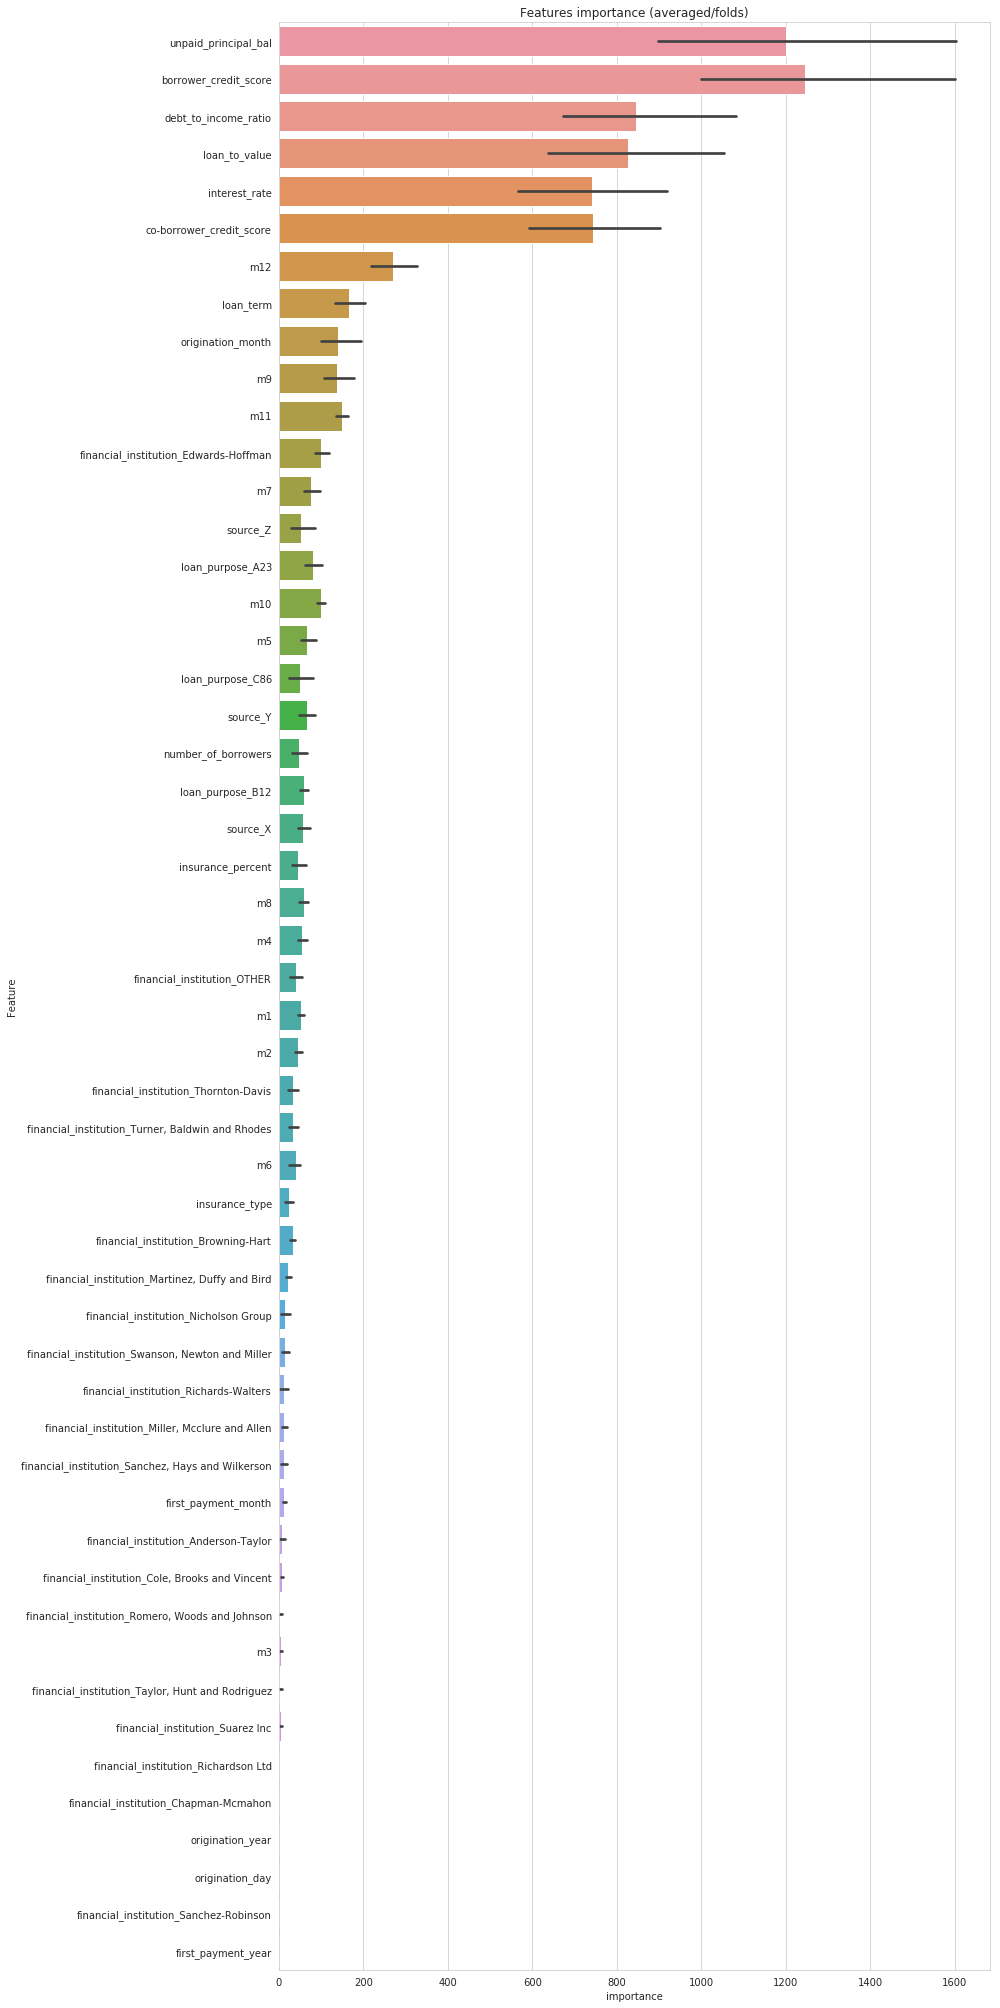

In [48]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [49]:
# #Adversarial Validation

# train_df['istrain'] =1
# test_df['istrain'] =0


# combined=pd.concat([train_df,test_df])
# target_adv = combined['istrain']


# folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=888)
# oof = np.zeros(len(combined))

# for fold_, (trn_idx, val_idx) in enumerate(folds.split(combined.values, target_adv.values)):
#     print("Fold {}".format(fold_))
#     trn_data = lgb.Dataset(combined.iloc[trn_idx][features], label=target_adv.iloc[trn_idx])
#     val_data = lgb.Dataset(combined.iloc[val_idx][features], label=target_adv.iloc[val_idx])

#     num_round = 1000000
#     clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, 
#                     early_stopping_rounds = 300)
#     oof[val_idx] = clf.predict(combined.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    

# print("CV score: {:<8.5f}".format(roc_auc_score(target_adv, oof)))